In [212]:
import pandas as pd
import numpy as np
import sklearn.model_selection as ml
import matplotlib.pyplot as plt
import copy


In [213]:
blobs2_dataset = pd.read_csv("../datasets/blobs2.csv")
blobs2_labels = blobs2_dataset["label"] * 2 - 1
blobs2_points = blobs2_dataset.drop("label", axis=1)



In [214]:
class PocketPerceptron:
    def __init__(self, dim, data, labels, num_iter):
        self.dim = dim
        self.data = data
        self.labels = labels
        self.num_iter = num_iter

        self.weights = np.random.rand(self.dim)

        self._precalc()

    @staticmethod
    def _extend_with_free_coef(data):
        length = data.shape[0]
        return np.hstack((data, np.ones((length, 1))))

    def _err_count(self, labels_new):
        return np.sum(labels_new != self.labels)

    def _predict(self, data):
        return data @ self.weights

    @staticmethod
    def _to_label(vect):
        return (vect >= 0) * 2 - 1

    def _count_err_matr(self, extended_matr):
        return self._err_count(self._to_label(self._predict(extended_matr)))

    def _precalc(self):
        extended_matr = self._extend_with_free_coef(self.data)

        for _ in range(self.num_iter):
            pocket = self.weights

            best_count = self._count_err_matr(extended_matr)
            prev_best_count = best_count

            for ind, tup in enumerate(extended_matr):
                if self._to_label(self._predict(tup)) != self.labels.iloc[ind]:
                    self.weights += self.labels.iloc[ind] * tup

                    new_count = self._count_err_matr(extended_matr)
                    if new_count < best_count:
                        best_count = new_count
                        pocket = copy.deepcopy(self.weights)

            if prev_best_count <= best_count:
                self.weights = pocket

    @staticmethod
    def get_points_between(arr, num=1000):
        return np.linspace(np.min(arr), np.max(arr), num)

    def get_geom_repr(self):
        x = self.get_points_between(self.data["x"])
        k = self.weights[0]
        a = self.weights[1]
        b = self.weights[2]
        y = -(k * x + b) / a
        return x, y

    def predict(self, data):
        return self._to_label(self._predict(self._extend_with_free_coef(data)))



In [215]:

def draw_points(points, labels):
    plt.scatter(points[labels == 1]["x"], points[labels == 1]["y"], c='r')
    plt.scatter(points[labels == -1]["x"], points[labels == -1]["y"], c='g')


def draw_line(x, y):
    plt.plot(x, y, 'b', label='y=kx+b')
    plt.show()


def calc_via_perceptron(data, labels):
    dimension = data.shape[1]
    points_train, points_test, labels_train, labels_test = ml.train_test_split(data, labels, train_size=0.75)
    perceptron = PocketPerceptron(dimension + 1, points_train, labels_train, 30)

    print(f'Train accuracy: {np.mean(perceptron.predict(points_train) == labels_train)}')

    draw_points(points_train, labels_train)
    draw_line(*perceptron.get_geom_repr())
    plt.show()
    
    print(f'Test accuracy: {np.mean(perceptron.predict(points_test) == labels_test)}')

    draw_points(points_test, labels_test)
    draw_line(*perceptron.get_geom_repr())
    plt.show()



Train accuracy: 0.9773333333333334
Test accuracy: 0.976


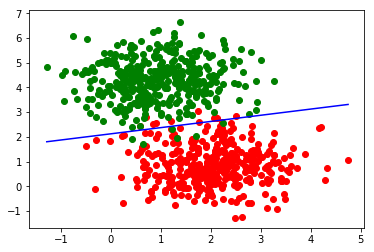

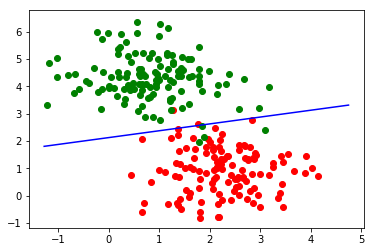

In [217]:
calc_via_perceptron(blobs2_points, blobs2_labels)



In [218]:
def setup_polynomial(data, degree, start_degree=1):
    result = copy.deepcopy(data)
    for max_deg in range(start_degree + 1, degree + 1):
        for cur_deg in range(max_deg + 1):
            x_deg = cur_deg
            y_deg = max_deg - cur_deg
            result[f"x^{x_deg} * y^{y_deg}"] = data["x"] ** x_deg * data["y"] ** y_deg
    return result



In [219]:
blobs2_points_2d = setup_polynomial(blobs2_points, 2)
blobs2_points_3d = setup_polynomial(blobs2_points, 3)
blobs2_points_4d = setup_polynomial(blobs2_points, 4)


In [220]:

def to_row(arr):
    return np.reshape(arr, (1, -1))


def to_col(arr):
    return np.reshape(arr, (-1, 1))


def eps_degree_matrix(total_points, x_points, y_points, weights, degree, start_degree=1):
    deg_matr = np.zeros((total_points, total_points))
    weight_ind = 0
    cur_weight = weights[weight_ind]
    for max_deg in range(start_degree, degree + 1):
        for cur_deg in range(max_deg + 1):
            x_deg = cur_deg
            y_deg = max_deg - cur_deg
            deg_matr += cur_weight * to_col(x_points ** x_deg) @ to_row(y_points ** y_deg)
            weight_ind += 1
            cur_weight = weights[weight_ind]
    # free coef
    deg_matr += cur_weight
    return np.absolute(deg_matr)


def draw_line_deg(data, deg, weights,  total_points=5_000):
    x_points = PocketPerceptron.get_points_between(data["x"], total_points)
    y_points = PocketPerceptron.get_points_between(data["y"], total_points)
    
    deg_matr = eps_degree_matrix(total_points, x_points, y_points, weights, deg)
    
    result = []
    #find points near hyperplane
    for ind_x, x in enumerate(x_points):
        for ind_y, y in enumerate(y_points):
            if deg_matr[ind_x, ind_y] < 0.1:
                result.append((x, y))
    plt.scatter([x for x, _ in result], [y for _, y in result], c='b', s=2)


def calc_via_perceptron_deg(data, labels, deg):
    dimension = data.shape[1]
    points_train, points_test, labels_train, labels_test = ml.train_test_split(data, labels, train_size=0.75)
    perceptron = PocketPerceptron(dimension + 1, points_train, labels_train, 30)

    print(f'Train accuracy: {np.mean(perceptron.predict(points_train) == labels_train)}')

    draw_points(points_train, labels_train)
    draw_line_deg(data, deg, perceptron.weights)
    plt.show()
    
    print(f'Test accuracy: {np.mean(perceptron.predict(points_test) == labels_test)}')

    draw_points(points_test, labels_test)
    draw_line_deg(data, deg, perceptron.weights)
    plt.show()


Train accuracy: 0.9786666666666667
Test accuracy: 0.972


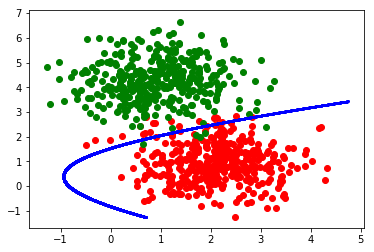

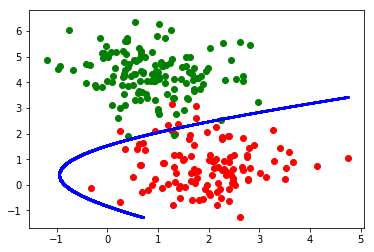

In [224]:
calc_via_perceptron_deg(blobs2_points_2d, blobs2_labels, 2)


Train accuracy: 0.98
Test accuracy: 0.968


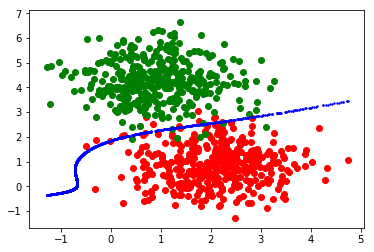

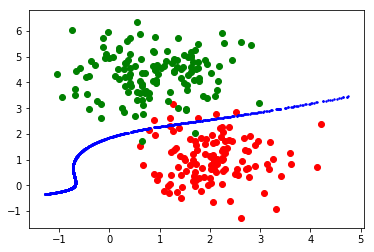

In [222]:
calc_via_perceptron_deg(blobs2_points_3d, blobs2_labels, 3)


Train accuracy: 0.9813333333333333
Test accuracy: 0.976


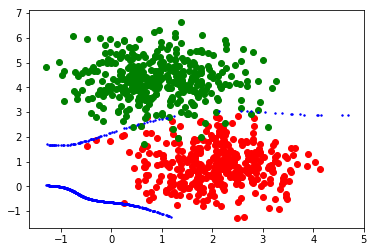

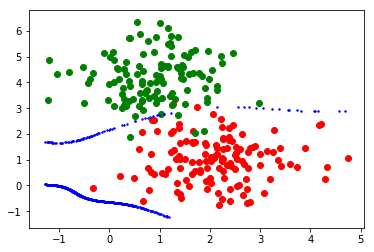

In [223]:
calc_via_perceptron_deg(blobs2_points_4d, blobs2_labels, 4)
